# Image Classfier for Multiclass problem on tuberculosis data classiying 'Normal', 'Cavitry' and 'Millary'

# Use Data Augment Notebook to Augment data First

In [1]:
#Liberaries
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
from keras.models import Sequential , load_model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import os
import tensorflow as tf

Using TensorFlow backend.


In [22]:
#path for train data
dataset_path_train = r"Data Set\Train\trainData"

In [23]:
#create dataframe for train data
filenames = os.listdir(dataset_path_train)
categories = []
for filename in filenames:
    category = filename.split(" ")[0]
    if category == 'Normal':
        categories.append('Normal')
    elif category == 'Cavitry':
        categories.append('Cavitry')
    elif category == "Millary":
        categories.append('Millary')

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [24]:
# Train DataFrame
df.head(10)

,filename,category
0,Cavitry 0.png,Cavitry
1,Cavitry 1.png,Cavitry
2,Cavitry 10.png,Cavitry
3,Cavitry 100.png,Cavitry
4,Cavitry 101.png,Cavitry
5,Cavitry 102.png,Cavitry
6,Cavitry 103.png,Cavitry
7,Cavitry 104.png,Cavitry
8,Cavitry 105.png,Cavitry
9,Cavitry 106.png,Cavitry


In [25]:
# Classes in Train Data
df.category.unique()

array(['Cavitry', 'Millary', 'Normal'], dtype=object)

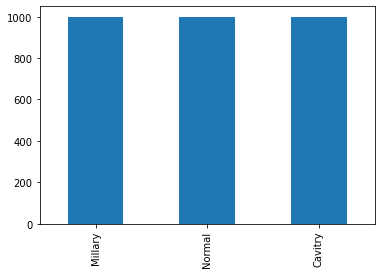

In [26]:
#Check if Classes are balanced
df['category'].value_counts().plot.bar()

In [27]:
#Parameters to reshape images before passing to model
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
batch_size=10

In [28]:
#SPlit Train and Validation data
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42, stratify=df[['category']])
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [29]:
#Size of train and validation data
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

In [30]:
# Data Generators for train and Validation

datagen = ImageDataGenerator(
    rotation_range=10,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)


train_generator = datagen.flow_from_dataframe(
    train_df,
    dataset_path_train,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)


validation_generator = datagen.flow_from_dataframe(
    validate_df, 
    dataset_path_train,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 2400 validated image filenames belonging to 3 classes.
Found 600 validated image filenames belonging to 3 classes.


In [31]:
#creates model 

def create_model():
    kernel_size = (3,3)
    pool_size= (2,2)
    first_filters = 32
    second_filters = 64
    third_filters = 128
    fourth_filters = 256

    dropout_conv = 0.1

    dropout_dense = 0.2


    model = Sequential()
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = pool_size)) 
    model.add(Dropout(dropout_conv))

    model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    model.add(MaxPooling2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))

    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    model.add(MaxPooling2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))

    model.add(Flatten())
    model.add(Dense(fourth_filters, activation = "relu"))
    model.add(Dropout(dropout_dense))
    model.add(Dense(3, activation = "softmax"))  # since we have 3 classes, normal, cavitry and millary

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model
    

In [32]:
model = create_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 124, 124, 32)      9248      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 122, 122, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 59, 59, 64)        18496     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 57, 57, 64)       

In [33]:
# train and validation steps for train and validation

train_batch_size = 20
val_batch_size = 20


train_steps = np.ceil(train_generator.samples / train_batch_size)
val_steps = np.ceil(validation_generator.samples / val_batch_size)

In [34]:
#Paramenter to train model
no_epochs =  25
shuffle = True
verbose = 1
save_weights_only = True
save_best_only = True

In [35]:
#train model

model_checkpoint= ModelCheckpoint('ImageClassifierModel{epoch:02d}.h5',save_weights_only=save_weights_only, save_best_only=save_best_only, monitor='val_loss', mode='min')
callbacks = [model_checkpoint]
history = model.fit_generator(
    train_generator, 
    epochs=no_epochs,
    validation_data=validation_generator,
    validation_steps=val_steps,
    steps_per_epoch= train_steps, 
    verbose=verbose,
    shuffle=shuffle,
    callbacks = callbacks
    
)

Epoch 1/25
120/120 [==============================] - 337s 3s/step - loss: 1.1319 - accuracy: 0.3450 - val_loss: 1.0988 - val_accuracy: 0.3233
Epoch 2/25
120/120 [==============================] - 351s 3s/step - loss: 1.2091 - accuracy: 0.3708 - val_loss: 0.8124 - val_accuracy: 0.4700
Epoch 3/25
120/120 [==============================] - 291s 2s/step - loss: 1.0674 - accuracy: 0.4350 - val_loss: 1.0813 - val_accuracy: 0.4600
Epoch 4/25
120/120 [==============================] - 333s 3s/step - loss: 1.0404 - accuracy: 0.4583 - val_loss: 0.8456 - val_accuracy: 0.5900
Epoch 5/25
120/120 [==============================] - 290s 2s/step - loss: 0.8367 - accuracy: 0.6242 - val_loss: 0.5671 - val_accuracy: 0.7200
Epoch 6/25
120/120 [==============================] - 309s 3s/step - loss: 0.6929 - accuracy: 0.7017 - val_loss: 0.8437 - val_accuracy: 0.6933
Epoch 7/25
120/120 [==============================] - 287s 2s/step - loss: 0.6192 - accuracy: 0.7092 - val_loss: 0.7668 - val_accuracy: 0.7500

In [53]:
#save weights of best model
model.save_weights(filepath='final_weight.h5')

In [54]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


<Figure size 432x288 with 0 Axes>

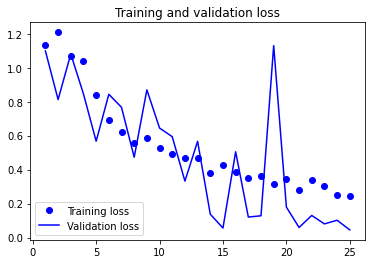

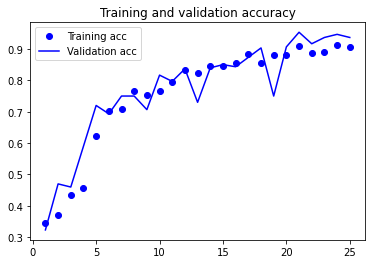

<Figure size 432x288 with 0 Axes>

In [55]:
#Plot accuracy and validation loss

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

In [72]:
#Path for test data
dataset_path_test = r"Data Set\Test\testData"

In [73]:
#DataFrame for test data
filenames = os.listdir(dataset_path_test)
categories = []
for filename in filenames:
    category = filename.split(" ")[0]
    if category == 'Normal':
        categories.append('Normal')
    elif category == 'Cavitry':
        categories.append('Cavitry')
    elif category == "Millary":
        categories.append('Millary')

df_test = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [74]:
df_test.head(10)

,filename,category
0,Cavitry 0.png,Cavitry
1,Cavitry 1.png,Cavitry
2,Cavitry 10.png,Cavitry
3,Cavitry 11.png,Cavitry
4,Cavitry 12.png,Cavitry
5,Cavitry 13.png,Cavitry
6,Cavitry 14.png,Cavitry
7,Cavitry 2.png,Cavitry
8,Cavitry 3.png,Cavitry
9,Cavitry 4.png,Cavitry


In [75]:
df_test.category.unique()

array(['Cavitry', 'Millary', 'Normal'], dtype=object)

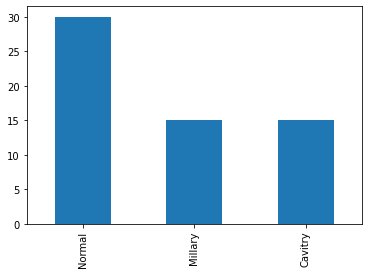

In [76]:
df_test['category'].value_counts().plot.bar()

In [77]:
#Data generator for test data

dataGen_test = ImageDataGenerator(
            rescale=1./255,
        )

test_generator = dataGen_test.flow_from_dataframe(
    df_test, 
    dataset_path_test,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 60 validated image filenames belonging to 3 classes.


In [78]:
#load weights of best model
model.load_weights('final_weight.h5')

In [79]:
#Evaluate model on test data
test_loss, test_acc = model.evaluate_generator(test_generator)

print('test_loss:', test_loss)
print('test_acc:', test_acc)

test_loss: 0.007808114401996136
test_acc: 0.7833333611488342


In [80]:
# Get target label names in numerical order of model
target_names = np.empty([1, 3],dtype=object)[0]
for key , value in test_generator.class_indices.items():
    target_names[value] =  key
target_names = list(target_names)

In [81]:
#Confution Matrix using predict generator

Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
cnf_matrix = confusion_matrix(test_generator.classes, y_pred)

confusion_matrix = pd.DataFrame(cnf_matrix, columns = target_names, index= target_names)
print('Confusion Matrix')
confusion_matrix


Confusion Matrix


,Cavitry,Millary,Normal
Cavitry,6,0,9
Millary,0,15,0
Normal,3,1,26


In [82]:
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# true positive rate
TPR = TP/(TP+FN)
# false poitive rate
FPR = FP/(FP+TN) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
TNR = TN/(TN+FN)
# False negative rate
FNR = FN/(TP+FN)
ERR = (FP+FN)/(TP+FP+FN+TN)
# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

In [83]:
Multiclass_Evaluation_Matrix = pd.DataFrame([FP,FN,TP,TN, TPR , FPR , TNR,FNR,ERR,  ACC], columns = target_names, index= ['False Positive', 'Fase Negitive', 'True Positive', 'True Negetive', 'True Positive Rate', 'False Positive Rate', 'True Negetiev Rate','False Negetive rate', 'Error Rate','Accuracy'])

In [84]:
#Evaluation Matrix
Multiclass_Evaluation_Matrix

,Cavitry,Millary,Normal
False Positive,3.000000,1.000000,9.000000
Fase Negitive,9.000000,0.000000,4.000000
True Positive,6.000000,15.000000,26.000000
True Negetive,42.000000,44.000000,21.000000
True Positive Rate,0.400000,1.000000,0.866667
False Positive Rate,0.066667,0.022222,0.300000
True Negetiev Rate,0.823529,1.000000,0.840000
False Negetive rate,0.600000,0.000000,0.133333
Error Rate,0.200000,0.016667,0.216667
Accuracy,0.800000,0.983333,0.783333


In [85]:
#Classification Report
print('Classification Report')
target_names = np.empty([1, 3],dtype=object)[0]
for key , value in test_generator.class_indices.items():
    target_names[value] =  key
target_names = list(target_names)
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

     Cavitry       0.67      0.40      0.50        15
     Millary       0.94      1.00      0.97        15
      Normal       0.74      0.87      0.80        30

    accuracy                           0.78        60
   macro avg       0.78      0.76      0.76        60
weighted avg       0.77      0.78      0.77        60

